In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/aviachipta-narxini-bashorat-qilish/train_data.csv
/kaggle/input/aviachipta-narxini-bashorat-qilish/test_data.csv
/kaggle/input/aviachipta-narxini-bashorat-qilish/sample_solution.csv


In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error

from sklearn import linear_model
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures


# manual nested cross-validation for random forest on a classification dataset
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [3]:
train=pd.read_csv("/kaggle/input/aviachipta-narxini-bashorat-qilish/train_data.csv")
test=pd.read_csv("/kaggle/input/aviachipta-narxini-bashorat-qilish/test_data.csv")
sample_sub=pd.read_csv("/kaggle/input/aviachipta-narxini-bashorat-qilish/sample_solution.csv")

In [4]:
test_id=test[['id']]

In [5]:
train.head()

,id,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,1,Vistara,UK-810,Bangalore,Early_Morning,one,Night,Mumbai,Economy,14.25,21,7212
1,2,SpiceJet,SG-5094,Hyderabad,Evening,zero,Night,Kolkata,Economy,1.75,7,5292
2,3,Vistara,UK-846,Bangalore,Morning,one,Evening,Delhi,Business,9.58,5,60553
3,4,Vistara,UK-706,Kolkata,Morning,one,Evening,Hyderabad,Economy,6.75,28,5760
4,5,Indigo,6E-5394,Chennai,Early_Morning,zero,Morning,Mumbai,Economy,2.00,4,10712


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                20000 non-null  int64  
 1   airline           20000 non-null  object 
 2   flight            20000 non-null  object 
 3   source_city       20000 non-null  object 
 4   departure_time    20000 non-null  object 
 5   stops             20000 non-null  object 
 6   arrival_time      20000 non-null  object 
 7   destination_city  20000 non-null  object 
 8   class             20000 non-null  object 
 9   duration          20000 non-null  float64
 10  days_left         20000 non-null  int64  
 11  price             20000 non-null  int64  
dtypes: float64(1), int64(3), object(8)
memory usage: 1.8+ MB


In [7]:
train.describe()

,id,duration,days_left,price
count,20000.000000,20000.000000,20000.000000,20000.000000
mean,10000.500000,12.177627,25.924150,20960.281700
std,5773.647028,7.157944,13.624874,22775.459535
min,1.000000,0.830000,1.000000,1105.000000
25%,5000.750000,6.830000,14.000000,4783.000000
50%,10000.500000,11.250000,26.000000,7425.000000
75%,15000.250000,16.080000,38.000000,42521.000000
max,20000.000000,38.580000,49.000000,114523.000000


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='airline'>

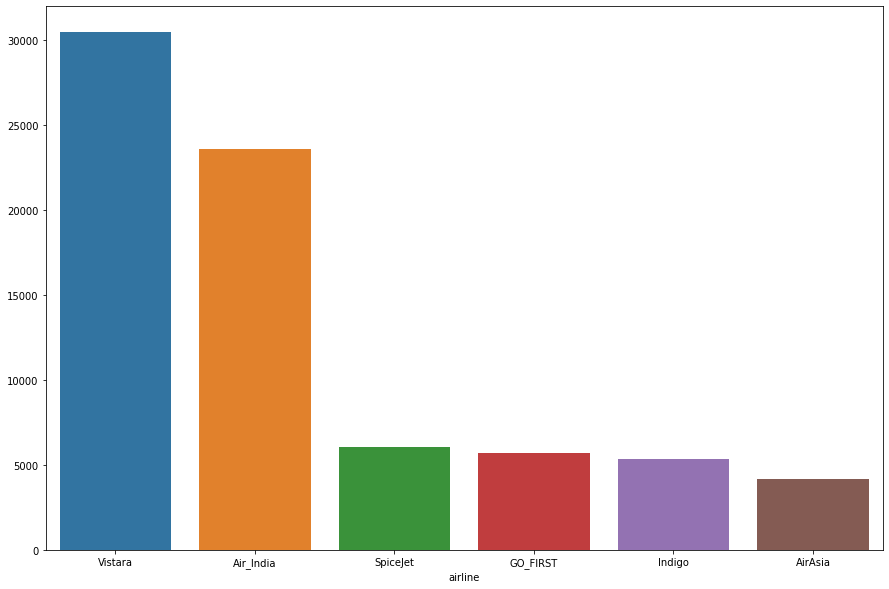

In [8]:
Airprices=train.groupby('airline')['price'].mean().sort_values(ascending=False)
plt.figure(figsize=(15,10))
sns.barplot(Airprices.index,Airprices.values)

<function matplotlib.pyplot.show(close=None, block=None)>

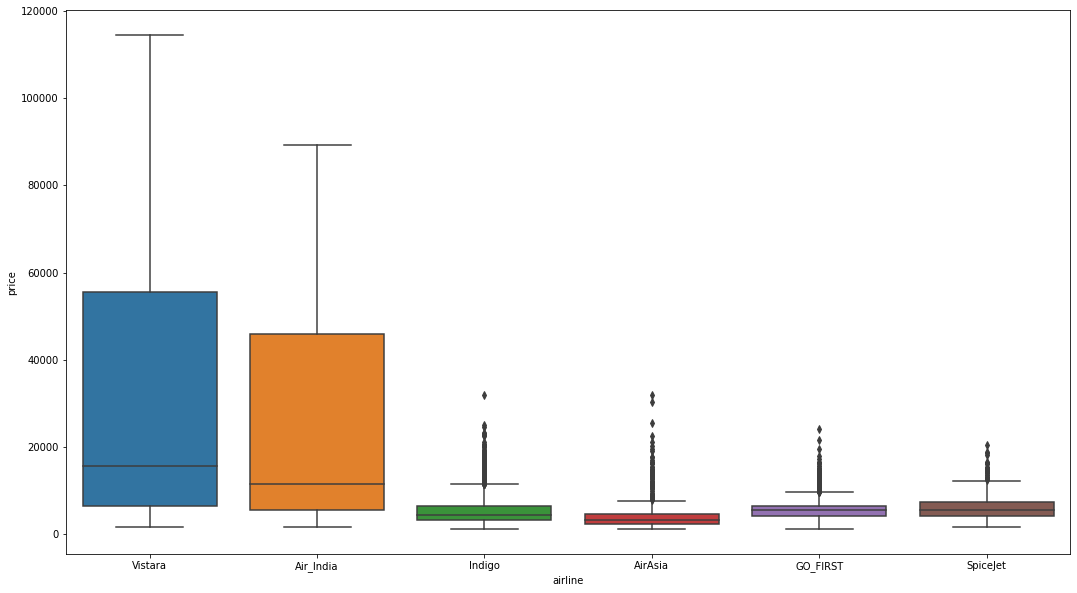

In [9]:
plt.figure(figsize=(18,10))
sns.boxplot(y='price',x='airline',data= train.sort_values('price',ascending=False))
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

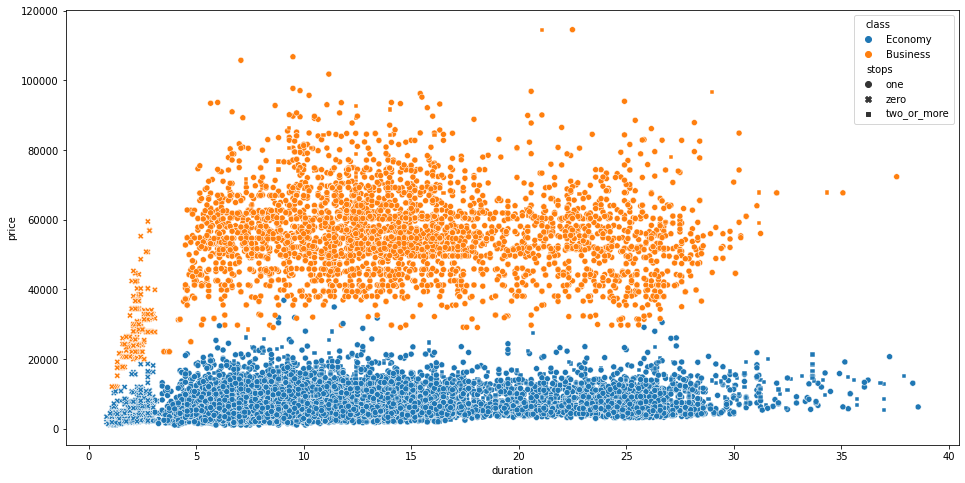

In [10]:
plt.figure(figsize=(16,8))
sns.scatterplot(data=train,x='duration',y='price',hue='class',style='stops')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

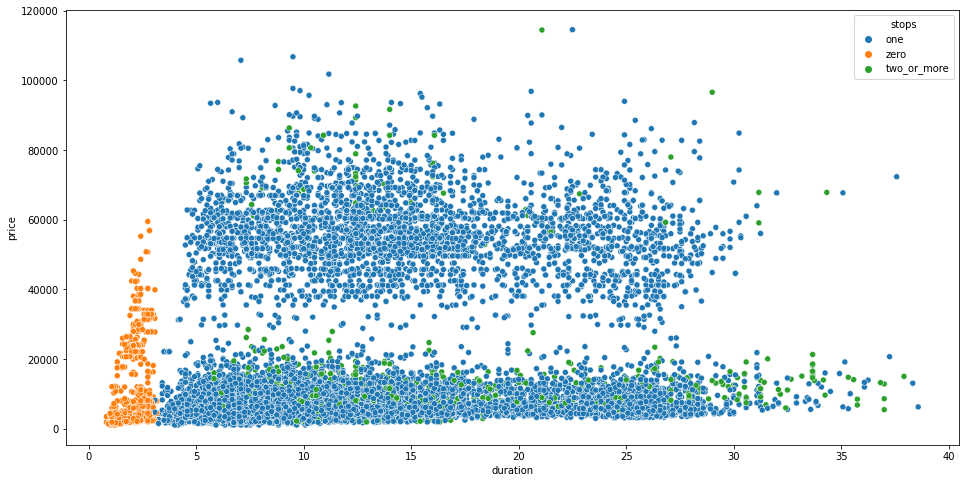

In [11]:
plt.figure(figsize=(16,8))
sns.scatterplot(data=train,x='duration',y='price',hue='stops')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

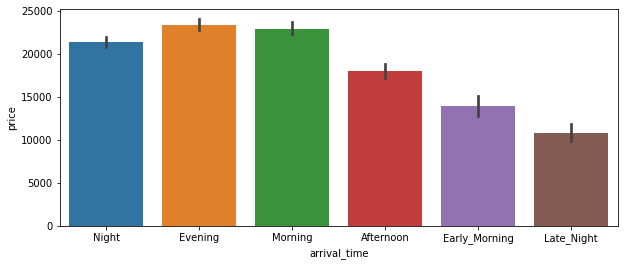

In [12]:
plt.figure(figsize=(10,4))
sns.barplot(data=train,y='price',x='arrival_time')
plt.show

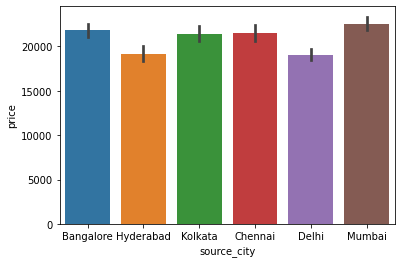

In [13]:
sns.barplot(data=train,x='source_city',y='price')
plt.show()

In [14]:
train['source_city'].max()

'Mumbai'

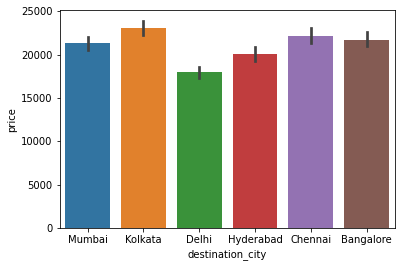

In [15]:
sns.barplot(data=train,x='destination_city',y='price')
plt.show()

In [16]:
#train.replace({'Vistara':10, 'SpiceJet':3, 'Indigo':2.8, 'Air_India':7, 'GO_FIRST':3,'AirAsia':2.6},inplace=True)
train.replace({'Bangalore':3, 'Hyderabad':2, 'Kolkata':5, 'Chennai':4, 'Delhi':1, 'Mumbai':6},inplace=True)
#train.replace({'Early_Morning':0.1, 'Evening':0.2, 'Morning':0.3, 'Afternoon':0.4, 'Night':0.5,'Late_Night':0.6},inplace=True)
#train.replace({'one':1, 'zero':0, 'two_or_more':2},inplace=True)
#train.replace({'Economy':10.2, 'Business':100.2},inplace=True)


#test.replace({'Vistara':10, 'SpiceJet':3, 'Indigo':2.8, 'Air_India':7, 'GO_FIRST':3,'AirAsia':2.6},inplace=True)
test.replace({'Bangalore':3, 'Hyderabad':2, 'Kolkata':5, 'Chennai':4, 'Delhi':1, 'Mumbai':6},inplace=True)
#test.replace({'Early_Morning':0.1, 'Evening':0.2, 'Morning':0.3, 'Afternoon':0.4, 'Night':0.5,'Late_Night':0.6},inplace=True)
#test.replace({'one':1, 'zero':0, 'two_or_more':2},inplace=True)
#test.replace({'Economy':10.2, 'Business':100.2},inplace=True)


In [17]:
test.head()

,id,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left
0,1,Air_India,AI-765,5,Evening,one,Night,1,Business,28.25,2
1,2,Vistara,UK-747,1,Early_Morning,one,Night,6,Business,13.83,34
2,3,Air_India,AI-570,6,Early_Morning,zero,Early_Morning,4,Business,2.00,30
3,4,AirAsia,I5-974,2,Night,one,Late_Night,1,Economy,5.17,26
4,5,Air_India,AI-770,5,Night,one,Afternoon,6,Economy,16.33,35


In [18]:
#train['mas']=df['mas']
#test['mas']=df1['mas']

In [19]:
train['mas']=(train['destination_city']*train['source_city'])**(1/10)
df=pd.DataFrame(train['mas'])
test['mas']=(test['destination_city']*test['source_city'])**(1/10)
df1=pd.DataFrame(test['mas'])
df1

,mas
0,1.174619
1,1.196231
2,1.374109
3,1.071773
4,1.405116
...,...
4995,1.311019
4996,1.405116
4997,1.405116
4998,1.282089


In [20]:
train.corrwith(train['price']).abs().sort_values(ascending=False)

price               1.000000
duration            0.213158
days_left           0.102545
mas                 0.098284
destination_city    0.057733
source_city         0.053869
id                  0.002443
dtype: float64

In [21]:
train.drop(['id'],axis=1,inplace=True)
test.drop(['id'],axis=1,inplace=True)

<AxesSubplot:>

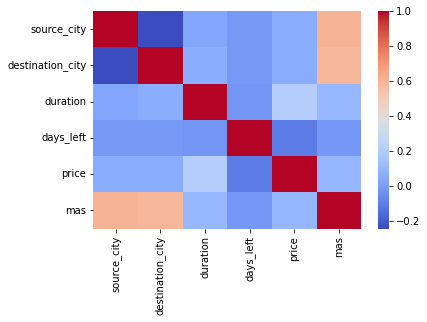

In [22]:
sns.heatmap(train.corr(),cmap='coolwarm')

In [23]:
X=train.drop('price',axis=1)
y=np.asanyarray(train[['price']])

In [24]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   airline           20000 non-null  object 
 1   flight            20000 non-null  object 
 2   source_city       20000 non-null  int64  
 3   departure_time    20000 non-null  object 
 4   stops             20000 non-null  object 
 5   arrival_time      20000 non-null  object 
 6   destination_city  20000 non-null  int64  
 7   class             20000 non-null  object 
 8   duration          20000 non-null  float64
 9   days_left         20000 non-null  int64  
 10  price             20000 non-null  int64  
 11  mas               20000 non-null  float64
dtypes: float64(2), int64(4), object(6)
memory usage: 1.8+ MB


In [25]:
train.columns

Index(['airline', 'flight', 'source_city', 'departure_time', 'stops',
       'arrival_time', 'destination_city', 'class', 'duration', 'days_left',
       'price', 'mas'],
      dtype='object')

In [26]:
cat_attr=['airline', 'flight', 'departure_time', 'stops','arrival_time','class','stops','arrival_time']
num_attr=['source_city', 'destination_city','duration', 'days_left','mas']

full_pip=ColumnTransformer([
    ('num',StandardScaler(),num_attr),
    ('cat',OrdinalEncoder(),cat_attr)
])

In [27]:
x=full_pip.fit_transform(X)

In [28]:
x_test=full_pip.fit_transform(test)

In [29]:
x_train,x_val,y_train,y_val=train_test_split(x,y,test_size=0.25,random_state=4)

# randomforest 

In [30]:
javob = []
for N in range(5):
    model = RandomForestRegressor(random_state=N, n_jobs=9, n_estimators=100)
    model.fit(x_train, y_train)
    preds_valid = model.predict(x_val)
    test_preds = model.predict(x_test)
    javob.append(test_preds)
    print(mean_squared_error(y_val, preds_valid, squared=False))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


3283.1592716807622


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


3312.445514538202


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


3291.2062705491862


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


3310.173288228296


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


3303.6582608090653


# Decision Tree

In [31]:
tree_model=DecisionTreeClassifier()
tree_model.fit(x_train,y_train)

DecisionTreeClassifier()

In [32]:
y_tree=tree_model.predict(x_val)
mae=mean_absolute_error(y_tree,y_val)
mse = mean_squared_error(y_tree, y_val)
print("MAE=", np.around(mae))
print("RMSE=", np.around(np.sqrt(mse)))

MAE= 1882.0
RMSE= 4689.0


# Random Forest

In [33]:
RF_model=RandomForestRegressor(n_estimators=100)
RF_model.fit(x_train,y_train)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestRegressor()

In [34]:
y_RF=RF_model.predict(x_val)

In [35]:
mae=mean_absolute_error(y_RF,y_val)
mse = mean_squared_error(y_RF, y_val)
print("MAE=", np.around(mae))
print("RMSE=", np.around(np.sqrt(mse)))

MAE= 1639.0
RMSE= 3320.0


# XGBRegressor

In [36]:
from xgboost import XGBRegressor
xgb_model=XGBRegressor()
xgb_model.fit(x_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [37]:
y_pred = xgb_model.predict(x_val)

In [38]:
y_xgb=xgb_model.predict(x_val)
mae=mean_absolute_error(y_xgb,y_val)
mse = mean_squared_error(y_pred, y_val)
print("MAE=", np.around(mae))
print("RMSE=", np.around(np.sqrt(mse)))

MAE= 1918.0
RMSE= 3345.0


# Cross validation

In [39]:
x_train,x_val,y_train,y_val=train_test_split(x,y,test_size=0.2,random_state=49,shuffle=True)

In [40]:
from sklearn.model_selection import cross_val_predict
pred=cross_val_predict(estimator=RF_model,X=x_train,y=y_train,cv=10)
pred

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:1044: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:1044: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:1044: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:1044: DataConversionWarning: A column-vector y was passed whe

array([15935.03,  2549.18, 12899.2 , ...,  6262.61,  9358.18, 42216.1 ])

In [41]:
mae=mean_absolute_error(pred,y_train)
mse = mean_squared_error(pred, y_train)
print("MAE=", np.around(mae))
print("RMSE=", np.around(np.sqrt(mse)))

MAE= 1657.0
RMSE= 3384.0


# Predict Test

In [42]:
test_preds

array([51977.62, 44078.53, 22817.2 , ..., 50378.28, 46586.13, 46209.97])

In [43]:
natija=pd.DataFrame(test_preds)

In [44]:
sub=pd.DataFrame({'price':test_preds})
sub

,price
0,51977.62
1,44078.53
2,22817.20
3,3124.59
4,6115.46
...,...
4995,60413.77
4996,4540.58
4997,50378.28
4998,46586.13


In [45]:
submission=pd.merge(test_id,sub,left_index=True,right_index=True)

submission

,id,price
0,1,51977.62
1,2,44078.53
2,3,22817.20
3,4,3124.59
4,5,6115.46
...,...,...
4995,4996,60413.77
4996,4997,4540.58
4997,4998,50378.28
4998,4999,46586.13


In [46]:
submission.to_csv('aviachiptapredict.csv',index=False)